<a href="https://colab.research.google.com/github/moon2su/ML-programming/blob/main/HAR_simple_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/Colab Notebooks/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/Colab Notebooks/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    #one hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

from sklearn.model_selection import train_test_split

X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.2,random_state=100)

from sklearn.preprocessing import StandardScaler

# ---------- 데이터 스케일링 함수 ----------
def scale_3d_timeseries(X_train, X_val, X_test=None):
    """
    3D 시계열 (N, T, F) 형태의 데이터를 feature-wise로 표준화
    """
    N, T, F = X_train.shape
    scaler = StandardScaler()

    scaler.fit(X_train.reshape(-1, F))

    def transform_3d(X):
        if X is None:
            return None
        N_, T_, F_ = X.shape
        X2 = X.reshape(-1, F_)
        X2 = scaler.transform(X2)
        return X2.reshape(N_, T_, F_)

    X_train_scaled = transform_3d(X_train)
    X_val_scaled = transform_3d(X_val)
    X_test_scaled = transform_3d(X_test)

    return X_train_scaled, X_val_scaled, X_test_scaled, scaler

# ---------- 실행 ----------
X_train_scaled, X_val_scaled, X_test_scaled, scaler = scale_3d_timeseries(X_train, X_val, testX)

# 스케일링 후 shape 확인
print("Scaled shapes:")
print("X_train_scaled:", X_train_scaled.shape)
print("X_val_scaled:", X_val_scaled.shape)
print("X_test_scaled:", X_test_scaled.shape)
print("-------------------")

X_train.shape,X_val.shape,y_train_one_hot.shape,y_val_one_hot.shape,y_train.shape,y_val.shape

/tmp/ipython-input-2086117023.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-2086117023.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-2086117023.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-2086117023.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)
Scaled shapes:
X_train_scaled: (5881, 128, 9)
X_val_scaled: (1471, 128, 9)
X_test_scaled: (2947, 128, 9)
-------------------


((5881, 128, 9), (1471, 128, 9), (5881, 6), (1471, 6), (5881, 1), (1471, 1))

In [ ]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Input, Conv1D, MaxPooling1D, BatchNormalization,
                                     Activation, SpatialDropout1D, GlobalAveragePooling1D,
                                     Dense, Dropout, GaussianNoise)

# n_timesteps, n_features, n_outputs 는 기존 변수 그대로 사용
simple_cnn = Sequential([
    Input(shape=(n_timesteps, n_features)),

    GaussianNoise(0.01),  # 작은 노이즈로 견고성 ↑

    # Block 1
    Conv1D(128, kernel_size=5, padding='same', use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling1D(pool_size=5),
    SpatialDropout1D(0.10),

    # Block 2
    Conv1D(64, kernel_size=5, padding='same', use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling1D(pool_size=5),
    SpatialDropout1D(0.15),

    # Block 3
    Conv1D(32, kernel_size=5, padding='same', use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling1D(pool_size=5),
    SpatialDropout1D(0.20),

    # Flatten 대신 GAP
    GlobalAveragePooling1D(),

    Dense(256, activation='relu'),
    Dropout(0.35),
    Dense(n_outputs, activation='softmax')
])

# Label Smoothing으로 과적합 완화
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05)
opt  = tf.keras.optimizers.Adam(learning_rate=1e-3)

simple_cnn.compile(loss=loss, optimizer=opt, metrics=['accuracy'])
simple_cnn.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gaussian_noise_5                │ (None, 128, 9)         │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 128, 128)       │         5,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 128, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_15            │ (None, 25, 128)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 25, 64)         │        40,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 25, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_16 (MaxPooling1D) │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_16            │ (None, 5, 64)          │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 5, 32)          │        10,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 5, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_17 (MaxPooling1D) │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_17            │ (None, 1, 32)          │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_5      │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,846 (265.02 KB)

 Trainable params: 67,398 (263.27 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import Callback

class F1MacroCallback(Callback):
    def __init__(self, X_val, y_val, batch_size=256):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.bs = batch_size

    def on_epoch_end(self, epoch, logs=None):
        y_prob = self.model.predict(self.X_val, batch_size=self.bs, verbose=0)
        y_pred = y_prob.argmax(axis=1)
        y_true = self.y_val.argmax(axis=1)
        f1m = f1_score(y_true, y_pred, average='macro')
        logs = logs or {}
        logs['val_f1_macro'] = f1m
        print(f"\nval_f1_macro: {f1m:.4f}")

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

f1_cb = F1MacroCallback(X_val_scaled, y_val_one_hot, batch_size=256)

callbacks = [
    f1_cb,
    EarlyStopping(monitor='val_f1_macro', mode='max', patience=12, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_f1_macro', mode='max', factor=0.5, patience=5, min_lr=1e-5, verbose=1),
    ModelCheckpoint('best_simple_cnn_f1.keras', monitor='val_f1_macro', mode='max', save_best_only=True, verbose=1)
]

In [ ]:
model_history = simple_cnn.fit(
    X_train_scaled, y_train_one_hot,
    validation_data=(X_val_scaled, y_val_one_hot),
    epochs=30,
    batch_size=128,
    callbacks=callbacks + [f1_cb],
)

Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.5090 - loss: 1.3081
val_f1_macro: 0.9279

Epoch 1: val_f1_macro improved from -inf to 0.92795, saving model to best_simple_cnn_f1.keras

val_f1_macro: 0.9279
46/46 ━━━━━━━━━━━━━━━━━━━━ 15s 186ms/step - accuracy: 0.5126 - loss: 1.3007 - val_accuracy: 0.9266 - val_loss: 0.6171 - val_f1_macro: 0.9279 - learning_rate: 0.0010
Epoch 2/30
41/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9007 - loss: 0.5103
val_f1_macro: 0.9436

Epoch 2: val_f1_macro improved from 0.92795 to 0.94359, saving model to best_simple_cnn_f1.keras

val_f1_macro: 0.9436
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9026 - loss: 0.5062 - val_accuracy: 0.9402 - val_loss: 0.4073 - val_f1_macro: 0.9436 - learning_rate: 0.0010
Epoch 3/30
42/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9324 - loss: 0.4355
val_f1_macro: 0.9385

Epoch 3: val_f1_macro did not improve from 0.94359

val_f1_macro: 0.9385
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - ac

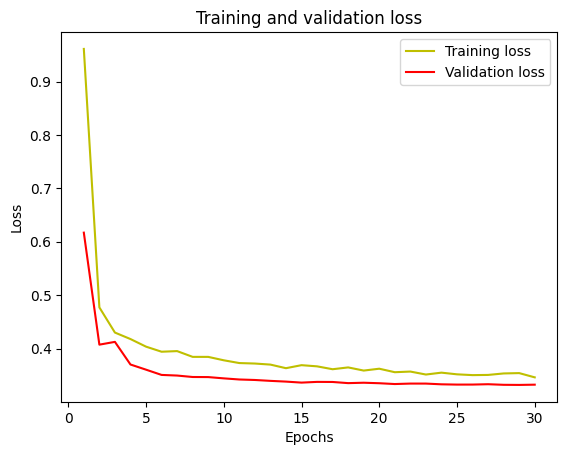

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

loss =model_history.history['loss']
val_loss =model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

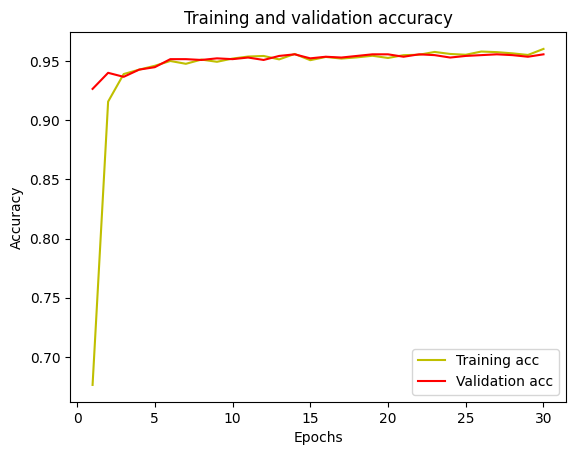

In [ ]:
acc =model_history.history['accuracy']
val_acc =model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Validation macro F1: 0.9588
Validation micro F1: 0.9558
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       243
           1       1.00      1.00      1.00       203
           2       1.00      1.00      1.00       207
           3       0.86      0.88      0.87       246
           4       0.89      0.88      0.88       281
           5       1.00      1.00      1.00       291

    accuracy                           0.96      1471
   macro avg       0.96      0.96      0.96      1471
weighted avg       0.96      0.96      0.96      1471



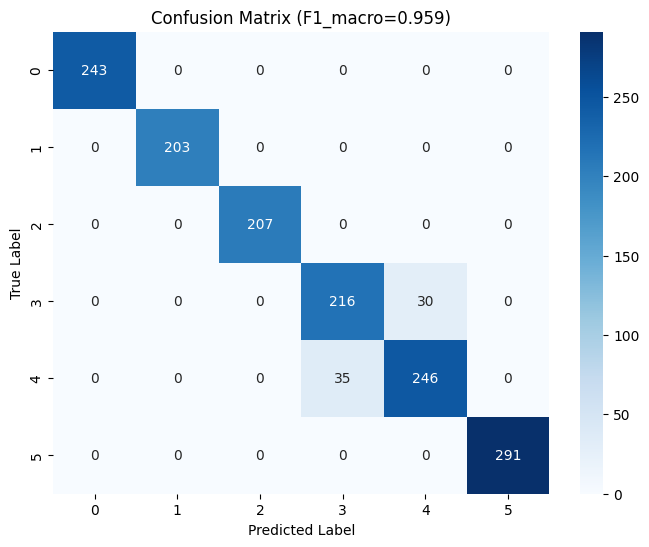

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import numpy as np

# 예측
y_val_prob = simple_cnn.predict(X_val_scaled, batch_size=256)
y_val_pred = y_val_prob.argmax(axis=1)
y_val_true = y_val_one_hot.argmax(axis=1)

# 혼동행렬
cm = confusion_matrix(y_val_true, y_val_pred)
f1_macro = f1_score(y_val_true, y_val_pred, average='macro')
f1_micro = f1_score(y_val_true, y_val_pred, average='micro')

# 결과 출력
print(f"Validation macro F1: {f1_macro:.4f}")
print(f"Validation micro F1: {f1_micro:.4f}")
print(classification_report(y_val_true, y_val_pred))

# -----------------------------
# 🔥 히트맵 시각화
# -----------------------------
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=np.unique(y_val_true),
            yticklabels=np.unique(y_val_true))
plt.title(f'Confusion Matrix (F1_macro={f1_macro:.3f})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
